In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'
TMPDIR = '/root/Internship-Valeo/Project/tmp'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points)

In [7]:
config = {
            'primitives': 'all',
            'truncate': {},
            'validation_size': -1,
            'test_size': -1,
            'on-the-fly': False,
            'cache_in_memory': False,
            'suffix': None,
            'add_augmentation_to_test_set': False,
            'num_parallel_calls': 10,
            'generation': {
                'split_sizes': {'training': 10000, 'validation': 200, 'test': 500},
                'image_size': [960, 1280],
                'random_seed': 0,
                'params': {
                    'generate_background': {
                        'min_kernel_size': 150, 'max_kernel_size': 500,
                        'min_rad_ratio': 0.02, 'max_rad_ratio': 0.031},
                    'draw_stripes': {'transform_params': (0.1, 0.1)},
                    'draw_multiple_polygons': {'kernel_boundaries': (50, 100)}
                },
            },
            'preprocessing': {
                'resize': [240, 320],
                'blur_size': 11,
            },
            'augmentation': {
                'photometric': {
                    'enable': True,
                    'primitives': 'all',
                    'params': {
                        'random_brightness': {'max_abs_change': 75},
                        'random_contrast': {'strength_range': [0.3, 1.8]},
                        'additive_gaussian_noise': {'stddev_range': [0, 15]},
                        'additive_speckle_noise': {'prob_range': [0, 0.0035]},
                        'additive_shade':{
                            'transparency_range': [-0.5, 0.8],
                            'kernel_size_range': [50, 100]},
                        'motion_blur': {'max_kernel_size': 7}},
                    'random_order': True,
                },
                'homographic': {
                    'enable': True,
                    'params': {
                        'translation': True,
                        'rotation': True,
                        'scaling': True,
                        'perspective': True,
                        'scaling_amplitude': 0.2,
                        'perspective_amplitude_x': 0.2,
                        'perspective_amplitude_y': 0.2,
                        'patch_ratio': 0.8,
                        'max_angle': 1.57,  # 3.14
                        'allow_artifacts': True,
                        'translation_overflow': 0.05,
                        'valid_border_margin': 2,
                    },
                    'valid_border_margin': 0,
                },
            }
    }

In [8]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [9]:
# code for photometric augmentation

primitives_photo = parse_primitives(config['primitives'], photaug.augmentations)

prim_configs = [config['augmentation']['photometric']['params'].get(p, {}) for p in primitives_photo]

indices = tf.range(len(primitives_photo))
if config['augmentation']['photometric']['random_order']:
    indices = tf.random.shuffle(indices)
def photo_aug_step(i, image):
    fn_pairs = [(tf.equal(indices[i], j), lambda p=p, c=c: getattr(photaug, p)(image, **c))
                for j, (p, c) in enumerate(zip(primitives_photo, prim_configs))]
    image = tf.case(fn_pairs)
    return i + 1, image

In [10]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [11]:
model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.4,
            'descriptor_size': 256,
            'batch_size': 2,
            'epochs': 25,
            'learning_rate': 0.001,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 0,
            'top_k': 0
    }

In [56]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_path, point_path, homography_path, seg_mask_path, 
                 warped_image_path, warped_point_path, warped_seg_mask_path, 
                 image_size_x = 320, image_size_y = 240,
                 is_training = True, batch_size = model_config['batch_size']):
        
        self.__ids = os.listdir(image_path)
        self.__image_path = image_path
        self.__point_path = point_path
        self.__homography_path = homography_path
        self.__seg_mask_path = seg_mask_path
        self.__warped_image_path = warped_image_path
        self.__warped_point_path = warped_point_path
        self.__warped_seg_mask_path = warped_seg_mask_path
        self.__image_size_x = image_size_x
        self.__image_size_y = image_size_y
        self.__batch_size = batch_size
        self.__is_training = is_training
        self.on_epoch_end()
        
    def __getitem__(self, index):
        images = []
        points_maps = []
        points_list = []
        
        homography_list = []
        seg_masks = []
        
        warped_images = []
        warped_points_maps = []
        warped_points_list = []
        
        warped_mask_images = []
        valid_masks = []
        
        if (index + 1)*self.__batch_size > len(self.__ids):
            self.__batch_size = len(self.__ids) - index * self.__batch_size
            
        file_batch = self.__ids[index * self.__batch_size : (index + 1) * self.__batch_size]
        
        for id_name in file_batch:
            img_file = os.path.join(self.__image_path,id_name)
            image = cv2.imread(img_file, 0)
            image = cv2.resize(image , (self.__image_size_x , self.__image_size_y))
            image = np.expand_dims(image, axis = 2)
            image_shape = tf.shape(image)[:2]
            
            point_file = os.path.join(self.__point_path,id_name+'.npy')
            points = _read_points(point_file)
            points = np.round(points).astype(int)
            
            if self.__is_training:
                # add photometric_augmentation
                _, image = tf.while_loop(lambda i, image: tf.less(i, len(primitives_photo)),
                                 photo_aug_step, [0, image], parallel_iterations=1)              
                
                # read homography file
                homography_file = os.path.join(self.__homography_path, id_name+'.npy')
                homography = _read_points(homography_file)
                
                # read segmentation masks
                mask_img_file = os.path.join(self.__seg_mask_path,id_name)
                mask_image = cv2.imread(mask_img_file, -1)
                mask_image = cv2.resize(mask_image , (self.__image_size_x , self.__image_size_y))
                mask_image = mask_image.reshape((self.__image_size_x , self.__image_size_y , 1))
                
                # read warped image
                warped_img_file = os.path.join(self.__warped_image_path,id_name)
                warped_image = cv2.imread(warped_img_file, 0)        
#                 warped_image = np.expand_dims(image, axis = 2)
                
                # read warped seg mask image
                warped_mask_img_file = os.path.join(self.__warped_seg_mask_path,id_name)
                warped_mask_image = cv2.imread(warped_mask_img_file, -1)
                warped_mask_image = cv2.resize(warped_mask_image , (self.__image_size_x , self.__image_size_y))
                warped_mask_image = warped_mask_image.reshape((self.__image_size_x , self.__image_size_y , 1))

                # compute valid mask
                valid_mask = compute_valid_mask(image_shape, homography,
                                         config['augmentation']['homographic']['valid_border_margin'])
                
                # read warped points
                warped_point_file = os.path.join(self.__warped_point_path,id_name+'.npy')
                warped_points = _read_points(warped_point_file)
                warped_points = filter_points(warped_points, image_shape)
                warped_points = np.round(warped_points).astype(int)
    
                warped_kp = tf.minimum(warped_points, image_shape-1)
                warped_points_map = tf.scatter_nd(warped_kp, tf.ones([tf.shape(warped_kp)[0]], 
                                                                     dtype=tf.int32), image_shape)
                        
                
                
                
                homography_list.append(homography)
                seg_masks.append(mask_image)
                warped_image = warped_image / 255.0
                warped_images.append(warped_image)
                warped_mask_images.append(warped_mask_image)
                valid_masks.append(valid_mask)
                warped_points_list.append(warped_points)
                warped_points_maps.append(warped_points_map)

            kp = tf.minimum(points, image_shape-1)
            points_map = tf.scatter_nd(kp, tf.ones([tf.shape(kp)[0]], dtype=tf.int32), image_shape)
            
            image = image / 255.0
            images.append(image)
            points_maps.append(points_map)
            points_list.append(points)
            
            
            
        images = np.array(images)
        points_maps = np.expand_dims(points_maps, axis = 3)
        
        if self.__is_training:
            warped_images = np.array(warped_images)
            warped_points_maps = np.expand_dims(warped_points_maps, axis = 3)
            homography_list = np.array(homography_list)
            warped_images = np.array(warped_images)
            warped_mask_images = np.array(warped_mask_images)
            valid_masks = np.array(valid_masks)
            dummy_loss_target = np.zeros(self.__batch_size)

            return [images,  seg_masks, #points_list,
                    homography_list, warped_images,
                    warped_mask_images, valid_masks, #warped_points_list
                   ], [points_maps, warped_points_maps, dummy_loss_target]
        
        else:
            return images, points_maps   
           
    def __len__(self):
        return int(np.ceil(len(self.__image_files) / float(self.__batch_size)))
    
    def on_epoch_end(self):
#         mydir = os.path.join(os.getcwd(), 'results')
#         mydir = os.path.join(mydir, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
#         os.makedirs(mydir)
#         model.save(mydir)
        pass

In [ ]:
def vgg_block(inputs, filters, kernel_size, name, data_format, training=False,
              batch_normalization=True, kernel_reg=0., **params):
    x = tfl.Convolution2D(filters, kernel_size, kernel_initializer='he_uniform',
                       kernel_regularizer=tf.keras.regularizers.L2(kernel_reg),
                       data_format=data_format, **params)(inputs)
    if batch_normalization:
        x = tfl.BatchNormalization(
                    fused=True,
                    axis=1 if data_format == 'channels_first' else -1)(x)
    return x

In [ ]:
def shared_encoder(model_config, shape = (240, 320,1)):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    pool_size=(2, 2)
    kernel = 3
    inputs = Input(shape)
    # Encoder
    conv1 = vgg_block(inputs, 64, (kernel, kernel), 'conv1_1', **params_conv)
    conv2 = vgg_block(conv1, 64, (kernel, kernel), 'conv1_2', **params_conv)
    pool1 = MaxPooling2D(pool_size, name="block1_pool")(conv2)

    conv3 = vgg_block(pool1, 64, (kernel, kernel), 'conv2_1', **params_conv)
    conv4 = vgg_block(conv3, 64, (kernel, kernel), 'conv2_2', **params_conv)
    pool2 = MaxPooling2D(pool_size, name="block2_pool")(conv4)

    conv5 = vgg_block(pool2, 128, (kernel, kernel), 'conv3_1', **params_conv)
    conv6 = vgg_block(conv5, 128, (kernel, kernel), 'conv3_2', **params_conv)
    pool3 = MaxPooling2D(pool_size, name="block3_pool")(conv6)

    conv7 = vgg_block(pool3, 128, (kernel, kernel), 'conv4_1', **params_conv)
    conv8 = vgg_block(conv7, 128, (kernel, kernel), 'conv4_2', **params_conv)
    return keras.models.Model(inputs = inputs, outputs = [conv8, conv7, conv6, conv5, conv4, conv3, 
                                                          conv2, conv1], name = 'shared_encoder')

In [ ]:
def detector_head(model_config, shape = (30, 40, 128)):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel

    inputs = Input(shape)
    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, 1+pow(model_config['grid_size'], 2), 1, 'conv2',
                      activation=None, **params_conv)

#     prob = tf.nn.softmax(x, axis=cindex)
#     # Strip the extra “no interest point” dustbin
#     prob = prob[:, :-1, :, :] if cfirst else prob[:, :, :, :-1]
#     prob = tf.nn.depth_to_space(
#               prob, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
#     prob = tf.squeeze(prob, axis=cindex)
#     return {'logits': x, 'prob': prob}
    return keras.models.Model(inputs = inputs, outputs = x, name = 'detector_head')

In [ ]:
def detector_loss(keypoint_map, logits, model_config = model_config, valid_mask=None):
    if model_config['data_format'] == 'channels_first':
        logits = tf.transpose(logits, [0, 2, 3, 1])
    # Convert the boolean labels to indices including the "no interest point" dustbin
    labels = keypoint_map#[..., tf.newaxis]  # for GPU
    labels = tf.cast(labels, tf.float32)
    labels = tf.nn.space_to_depth(labels, model_config['grid_size'])
    shape = tf.concat([tf.shape(labels)[:3], [1]], axis=0)
    labels = tf.concat([2*labels, tf.ones(shape)], 3)
    # Add a small random matrix to randomly break ties in argmax
    labels = tf.argmax(labels + tf.random.uniform(tf.shape(labels), 0, 0.1), axis=3)
    # Mask the pixels if bordering artifacts appear
#     valid_mask = tf.ones_like(keypoint_map) if valid_mask is None else valid_mask
#     valid_mask = valid_mask[..., tf.newaxis]  # for GPU
#     valid_mask = tf.cast(valid_mask, tf.float32)
#     valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
#     valid_mask = tf.math.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
 
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    return loss

def wrapper_fn(model_config):
    def loss_fn(y_true, y_pred):
        return detector_loss(y_true, y_pred, model_config = model_config)
#                              valid_mask=inputs['valid_mask'])
    return loss_fn

In [ ]:
def descriptor_head(shape, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel
    inputs = Input(shape)
    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, model_config['descriptor_size'], 1, 'conv2',
                      activation=None, **params_conv)

#     desc = tf.transpose(x, [0, 2, 3, 1]) if cfirst else x
#     desc = tf.image.resize_bilinear(
#             desc, model_config['grid_size'] * tf.shape(desc)[1:3])
#     desc = tf.transpose(desc, [0, 3, 1, 2]) if cfirst else desc
#     desc = tf.nn.l2_normalize(desc, cindex)

#     return {'descriptors_raw': x, 'descriptors': desc}
    return keras.models.Model(inputs = inputs, outputs = x, name = 'descriptor_head')

In [ ]:
def descriptor_loss(descriptors, warped_descriptors, homographies,
                    model_config = model_config, valid_mask=None):
    # Compute the position of the center pixel of every cell in the image
    (batch_size, Hc, Wc) = tf.unstack(tf.cast(tf.shape(descriptors)[:3], tf.int32))
    coord_cells = tf.stack(tf.meshgrid(
        tf.range(Hc), tf.range(Wc), indexing='ij'), axis=-1)
    coord_cells = coord_cells * model_config['grid_size'] + model_config['grid_size'] // 2  # (Hc, Wc, 2)
    # coord_cells is now a grid containing the coordinates of the Hc x Wc
    # center pixels of the 8x8 cells of the image

    # Compute the position of the warped center pixels
    warped_coord_cells = warp_points(tf.reshape(coord_cells, [-1, 2]), homographies)
    # warped_coord_cells is now a list of the warped coordinates of all the center
    # pixels of the 8x8 cells of the image, shape (N, Hc x Wc, 2)

    # Compute the pairwise distances and filter the ones less than a threshold
    # The distance is just the pairwise norm of the difference of the two grids
    # Using shape broadcasting, cell_distances has shape (N, Hc, Wc, Hc, Wc)
    coord_cells = tf.cast(tf.reshape(coord_cells, [1, 1, 1, Hc, Wc, 2]), tf.float32)
    warped_coord_cells = tf.reshape(warped_coord_cells,
                                    [batch_size, Hc, Wc, 1, 1, 2])
    cell_distances = tf.norm(coord_cells - warped_coord_cells, axis=-1)
    s = tf.cast(tf.less_equal(cell_distances, model_config['grid_size'] - 0.5), tf.float32)
    # s[id_batch, h, w, h', w'] == 1 if the point of coordinates (h, w) warped by the
    # homography is at a distance from (h', w') less than config['grid_size']
    # and 0 otherwise

    # Normalize the descriptors and
    # compute the pairwise dot product between descriptors: d^t * d'
    descriptors = tf.reshape(descriptors, [batch_size, Hc, Wc, 1, 1, -1])
    descriptors = tf.nn.l2_normalize(descriptors, -1)
    warped_descriptors = tf.reshape(warped_descriptors,
                                    [batch_size, 1, 1, Hc, Wc, -1])
    warped_descriptors = tf.nn.l2_normalize(warped_descriptors, -1)
    dot_product_desc = tf.reduce_sum(descriptors * warped_descriptors, -1)
    dot_product_desc = tf.nn.relu(dot_product_desc)
    dot_product_desc = tf.reshape(tf.nn.l2_normalize(
        tf.reshape(dot_product_desc, [batch_size, Hc, Wc, Hc * Wc]),
        3), [batch_size, Hc, Wc, Hc, Wc])
    dot_product_desc = tf.reshape(tf.nn.l2_normalize(
        tf.reshape(dot_product_desc, [batch_size, Hc * Wc, Hc, Wc]),
        1), [batch_size, Hc, Wc, Hc, Wc])
    # dot_product_desc[id_batch, h, w, h', w'] is the dot product between the
    # descriptor at position (h, w) in the original descriptors map and the
    # descriptor at position (h', w') in the warped image

    # Compute the loss
    positive_dist = tf.maximum(0., model_config['positive_margin'] - dot_product_desc)
    negative_dist = tf.maximum(0., dot_product_desc - model_config['negative_margin'])
    loss = model_config['lambda_d'] * s * positive_dist + (1 - s) * negative_dist

    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones([batch_size,
                          Hc * model_config['grid_size'],
                          Wc * model_config['grid_size']], tf.float32)\
        if valid_mask is None else valid_mask
    valid_mask = tf.cast(valid_mask[..., tf.newaxis], tf.float32)  # for GPU
    valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
    valid_mask = tf.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.reshape(valid_mask, [batch_size, 1, 1, Hc, Wc])

    normalization = tf.reduce_sum(valid_mask) * tf.cast(Hc * Wc, tf.float32)
    # Summaries for debugging
    # tf.summary.scalar('nb_positive', tf.reduce_sum(valid_mask * s) / normalization)
    # tf.summary.scalar('nb_negative', tf.reduce_sum(valid_mask * (1 - s)) / normalization)
    tf.summary.scalar('positive_dist', tf.reduce_sum(valid_mask * model_config['lambda_d'] *
                                                     s * positive_dist) / normalization)
    tf.summary.scalar('negative_dist', tf.reduce_sum(valid_mask * (1 - s) *
                                                     negative_dist) / normalization)
    loss = tf.reduce_sum(valid_mask * loss) / normalization
    return loss

In [ ]:
def segmentation_head(inputs, kernel = 3):
    conv9 = Conv2DTranspose(128, (kernel, kernel),strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(inputs[0])
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation("relu")(conv9)
    conv9 = concatenate( [inputs[0] , conv9]  , axis = -1)
    conv10 = Conv2DTranspose(128, (kernel, kernel), 
                              padding="same", kernel_initializer='he_uniform')(conv9)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation("relu")(conv10)
    conv10 = concatenate( [conv7 , conv10]  , axis = -1)


    conv11 = Conv2DTranspose(128, (kernel, kernel), strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(conv10)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation("relu")(conv11)
    conv11 = concatenate( [conv6 , conv11]  , axis = -1)
    
    conv12 = Conv2DTranspose(128, (kernel, kernel),padding="same", kernel_initializer='he_uniform')(conv11)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation("relu")(conv12)
    conv12 = concatenate( [conv5 , conv12]  , axis = -1)

    conv13 = Conv2DTranspose(64, (kernel, kernel),strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(conv12)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation("relu")(conv13)
    conv13 = concatenate( [conv4 , conv13]  , axis = -1)
    
    conv14 = Conv2DTranspose(64, (kernel, kernel), padding="same", kernel_initializer='he_uniform')(conv13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation("relu")(conv14)
    conv14 = concatenate( [conv3 , conv14]  , axis = -1)


    conv15 = Conv2DTranspose(64, (kernel, kernel), strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(conv14)
    conv15 = BatchNormalization()(conv15)
    conv15 = Activation("relu")(conv15)
    conv15 = concatenate( [conv2 , conv15]  , axis = -1)
    
    conv16 = Conv2DTranspose(64, (kernel, kernel), padding="same", kernel_initializer='he_uniform')(conv15)
    conv16 = BatchNormalization()(conv16)
    conv16 = concatenate( [conv1 , conv16]  , axis = -1)
    
    conv17 = Conv2DTranspose(1, (1, 1), padding="same", kernel_initializer='he_uniform')(conv16)
    conv17 = BatchNormalization()(conv17)
    conv17 = Activation('sigmoid')(conv17)
#     conv17 = Dense(1)(conv17)
#     outputs = Activation('softmax')(conv17)
    return keras.models.Model(inputs = inputs, outputs = conv17, name = 'segmentation_head')

In [ ]:
class HomographyLayer(Layer):
    def call(self, inputs):
        return inputs

def HomographyModel(shape = (8,)):
    x = Input(shape)
    output = HomographyLayer(name="homography_layer", trainable=False)(x)
    return keras.models.Model(inputs = x, outputs = output)

class DescriptorLossLayer(Layer):
    def __init__(self, name='descriptor_loss_layer', trainable=False):
        super(DescriptorLossLayer, self).__init__(name=name)
        self.loss_fn = descriptor_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = model_config['lambda_loss']*self.loss_fn(inputs[0], inputs[1], inputs[2])
        self.add_loss(loss)
        return tf.reshape(loss, (1,))
    def compute_output_shape(self, input_shape):
        return [1]
    
def net():
    
    images_input = Input(shape = (240, 320,1), name = 'images_input')
#     points_list_input = Input() 
    homography_list_input = Input(shape = (8,), name = 'homography_list_input') 
    warped_images_input = Input(shape = (240, 320,1), name = 'warped_images_input')
#     mask_images_input = Input(shape = (240, 320,1)) 
#     warped_mask_images_input = Input(shape = (240, 320,1)) 
#     valid_masks_input = Input(shape = (240, 320,1))
#     warped_points_list_input = Input()
    homography_model = HomographyModel()
    homography = homography_model(homography_list_input)
    
    encoder = shared_encoder(model_config = model_config)
    encoder_output = encoder(images_input)
    warped_encoder_output = encoder(warped_images_input)
    
    detector = detector_head(model_config = model_config)
    detector_output = detector(encoder_output)
    warped_detector_output = detector(warped_encoder_output)
    
    descriptor = descriptor_head(shape = (30, 40, 128), model_config=model_config)
    descriptor_output = descriptor(encoder_output)
    warped_descriptor_output = descriptor(warped_encoder_output)
    
#     semantics_model = segmentation_head(encoder_output)
#     semantics_output = semantics_model(encoder_output)
#     warped_semantics_output = semantics_model(encoder_output)
    
    loss_layer = DescriptorLossLayer()([descriptor_output, warped_descriptor_output, 
                                          homography])
    
    model = keras.models.Model(inputs = [images_input, #points_list_input,
                                         homography_list_input, warped_images_input,], 
                                         #warped_mask_images_input, valid_masks_input, 
                                         #warped_points_list_input], 
                               outputs = [detector_output, warped_detector_output,#, warped_descriptor_output, 
                                          #descriptor_output, homography
#                                           semantics_output, warped_semantics_output, 
                                          loss_layer])
    return model

In [ ]:
model = net()

In [ ]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=True, dpi=96)

In [ ]:
def model_metrics(y_true, y_pred):
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    y_pred = tf.nn.softmax(y_pred, axis=cindex)
    y_pred = tf.argmax(y_pred, axis =cindex)
  
    y_pred = tf.one_hot(y_pred, depth = 1+pow(model_config['grid_size'], 2))
    y_true = tf.nn.space_to_depth(y_true, model_config['grid_size'])
    y_true = tf.cast(y_true, tf.float32)
    # Strip the extra “no interest point” dustbin
    y_pred = y_pred[:, :-1, :, :] if cfirst else y_pred[:, :, :, :-1]
   
    precision = tf.math.reduce_sum(y_pred * y_true) /tf.math.reduce_sum(y_pred)
    recall = tf.math.reduce_sum(y_pred * y_true) / tf.math.reduce_sum(y_true)
#     return {'precision': precision, 'recall': recall}
    return precision

In [ ]:
detect_loss = wrapper_fn(model_config=model_config)

def descript_loss(dummy_target, y_pred):
    return tf.squeeze(y_pred)

def dummy_metrics(dummy_target, y_pred):
    return tf.squeeze(y_pred)

def dummy_metrics1(dummy_target, y_pred):
    return tf.squeeze(y_pred)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
              loss = [detect_loss,detect_loss, descript_loss],
             loss_weights=[1., 1., 1.])
#                        metrics = [model_metrics, dummy_metrics, dummy_metrics1])

In [ ]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="/root/Internship-Valeo/Project/results/mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,)

TerminateOnNaN = tf.keras.callbacks.TerminateOnNaN()

In [13]:
image_path_train = '/root/Internship-Valeo/Project/data/COCO/anntrain2014'
point_path_train = '/root/Internship-Valeo/Project/data/COCO/pointstrain2014'
homography_path_train = '/root/Internship-Valeo/Project/data/COCO/homographies_train'
seg_mask_path_train = '/root/Internship-Valeo/Project/data/COCO/masktrain2014'
warped_image_path_train = '/root/Internship-Valeo/Project/data/COCO/warptrain2014'
warped_point_path_train = '/root/Internship-Valeo/Project/data/COCO/warped_pointstrain2014'
warped_seg_mask_path_train = '/root/Internship-Valeo/Project/data/COCO/warp_mask_train2014'

In [32]:
train_gen = DataGen(image_path = image_path_train, point_path = point_path_train, 
                   homography_path = homography_path_train, seg_mask_path = seg_mask_path_train, 
                   warped_image_path = warped_image_path_train, warped_point_path = warped_point_path_train, 
                   warped_seg_mask_path = warped_seg_mask_path_train, 
                 image_size_x = 320, image_size_y = 240,
                 is_training = True, batch_size = model_config['batch_size'])


train_steps =  len(os.listdir(image_path_train))/model_config['batch_size']

# history = model.fit(train_gen , validation_data = val_gen, steps_per_epoch = train_steps, 
#                     epochs = 25, callbacks=[model_checkpoint_callback, TerminateOnNaN, tensorboard_callback])

In [33]:
# model.save('/root/Internship-Valeo/Project/results/checkpoint-magicpoint-no_aug')

In [34]:
x, y = train_gen.__getitem__(0)

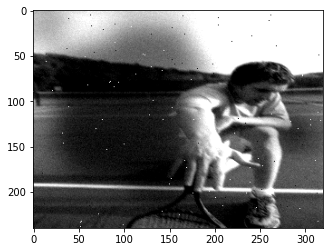

In [44]:
plt.imshow(x[0][0], cmap = 'gray')

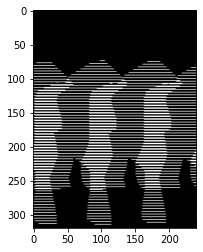

In [43]:
plt.imshow(x[1][0], cmap = 'gray')

In [45]:
image_path_val = '/root/Internship-Valeo/Project/data/COCO/annval2014'
point_path_val = '/root/Internship-Valeo/Project/data/COCO/pointsval2014'
homography_path_val = '/root/Internship-Valeo/Project/data/COCO/homographies_val'
seg_mask_path_val = '/root/Internship-Valeo/Project/data/COCO/maskval2014'
warped_image_path_val = '/root/Internship-Valeo/Project/data/COCO/warpval2014'
warped_point_path_val = '/root/Internship-Valeo/Project/data/COCO/warped_pointsval2014'
warped_seg_mask_path_val = '/root/Internship-Valeo/Project/data/COCO/warp_mask_val2014'

In [57]:
test_gen = DataGen(image_path = image_path_val, point_path = point_path_val, 
                   homography_path = homography_path_val, seg_mask_path = seg_mask_path_val, 
                   warped_image_path = warped_image_path_val, warped_point_path = warped_point_path_val, 
                   warped_seg_mask_path = warped_seg_mask_path_val, 
                 image_size_x = 320, image_size_y = 240,
                 is_training = True, batch_size = model_config['batch_size'])

In [58]:
x, y = test_gen.__getitem__(0)

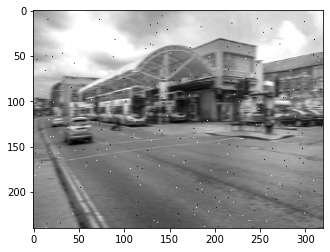

In [49]:
plt.imshow(x[0][0]*255, cmap = 'gray')

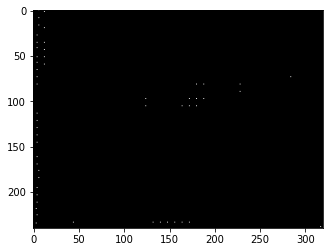

In [50]:
plt.imshow(y[0][0], cmap='gray')

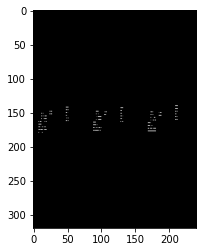

In [52]:
plt.imshow(x[1][0]*255, cmap = 'gray')

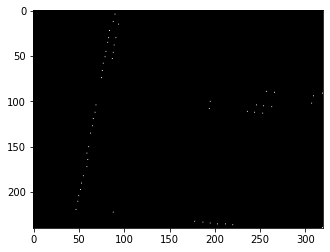

In [53]:
plt.imshow(y[1][0], cmap='gray')

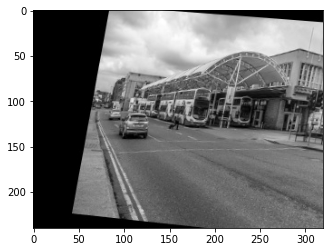

In [59]:
plt.imshow(x[3][0]*255, cmap = 'gray')

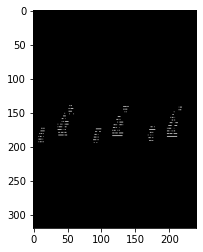

In [60]:
plt.imshow(x[4][0]*255, cmap = 'gray')

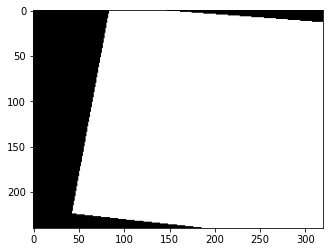

In [61]:
plt.imshow(x[5][0]*255, cmap = 'gray')

In [ ]:
result = model.predict(x)

In [ ]:
model.layers

In [ ]:
cfirst = model_config['data_format'] == 'channels_first'
cindex = 1 if cfirst else -1  # index of the channel
labels = tf.argmax(result[0], axis =cindex)
one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
# Strip the extra “no interest point” dustbin
one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
one_hot = tf.nn.depth_to_space(
              one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
one_hot = tf.squeeze(one_hot, axis=cindex)

plt.imshow((one_hot)[0], cmap = 'gray')

In [ ]:
descriptors= np.ones((2, 30,40,256)) 
warped_descriptors = np.ones((2, 30,40,256)) 

In [ ]:
# Compute the position of the center pixel of every cell in the image
(batch_size, Hc, Wc) = tf.unstack(tf.cast(tf.shape(descriptors)[:3], tf.int32))
coord_cells = tf.stack(tf.meshgrid(
        tf.range(Hc), tf.range(Wc), indexing='ij'), axis=-1)
coord_cells = coord_cells * model_config['grid_size'] + model_config['grid_size'] // 2  # (Hc, Wc, 2)
    # coord_cells is now a grid containing the coordinates of the Hc x Wc
    # center pixels of the 8x8 cells of the image


In [ ]:
coord_cells[0:10,0:10,0]

In [ ]:
homography1 = sample_homography((240,320), config['augmentation']['homographic']['params'])[0]
homography2 = sample_homography((240,320), config['augmentation']['homographic']['params'])[0]

In [ ]:
homographies = np.array([homography1, homography2])

In [ ]:
warped_coord_cells = warp_points(tf.reshape(coord_cells, [-1, 2]), homographies)
    # warped_coord_cells is now a list of the warped coordinates of all the center
    # pixels of the 8x8 cells of the image, shape (N, Hc x Wc, 2)

    # Compute the pairwise distances and filter the ones less than a threshold
    # The distance is just the pairwise norm of the difference of the two grids
    # Using shape broadcasting, cell_distances has shape (N, Hc, Wc, Hc, Wc)

In [ ]:
    coord_cells = tf.cast(tf.reshape(coord_cells, [1, 1, 1, Hc, Wc, 2]), tf.float32)
    warped_coord_cells = tf.reshape(warped_coord_cells,
                                    [batch_size, Hc, Wc, 1, 1, 2])
    cell_distances = tf.norm(coord_cells - warped_coord_cells, axis=-1)
    s = tf.cast(tf.less_equal(cell_distances, model_config['grid_size'] - 0.5), tf.float32)
    # s[id_batch, h, w, h', w'] == 1 if the point of coordinates (h, w) warped by the
    # homography is at a distance from (h', w') less than config['grid_size']
    # and 0 otherwise

    # Normalize the descriptors and
    # compute the pairwise dot product between descriptors: d^t * d'
    descriptors = tf.reshape(descriptors, [batch_size, Hc, Wc, 1, 1, -1])
    descriptors = tf.nn.l2_normalize(descriptors, -1)
    warped_descriptors = tf.reshape(warped_descriptors,
                                    [batch_size, 1, 1, Hc, Wc, -1])
    warped_descriptors = tf.nn.l2_normalize(warped_descriptors, -1)
    dot_product_desc = tf.reduce_sum(descriptors * warped_descriptors, -1)
    dot_product_desc = tf.nn.relu(dot_product_desc)
    dot_product_desc = tf.reshape(tf.nn.l2_normalize(
        tf.reshape(dot_product_desc, [batch_size, Hc, Wc, Hc * Wc]),
        3), [batch_size, Hc, Wc, Hc, Wc])
    dot_product_desc = tf.reshape(tf.nn.l2_normalize(
        tf.reshape(dot_product_desc, [batch_size, Hc * Wc, Hc, Wc]),
        1), [batch_size, Hc, Wc, Hc, Wc])
    # dot_product_desc[id_batch, h, w, h', w'] is the dot product between the
    # descriptor at position (h, w) in the original descriptors map and the
    # descriptor at position (h', w') in the warped image

    # Compute the loss
    positive_dist = tf.maximum(0., model_config['positive_margin'] - dot_product_desc)
    negative_dist = tf.maximum(0., dot_product_desc - model_config['negative_margin'])
    loss = model_config['lambda_d'] * s * positive_dist + (1 - s) * negative_dist

    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones([batch_size,
                          Hc * model_config['grid_size'],
                          Wc * model_config['grid_size']], tf.float32)\
        if valid_mask is None else valid_mask
    valid_mask = tf.cast(valid_mask[..., tf.newaxis], tf.float32)  # for GPU
    valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
    valid_mask = tf.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.reshape(valid_mask, [batch_size, 1, 1, Hc, Wc])

    normalization = tf.reduce_sum(valid_mask) * tf.cast(Hc * Wc, tf.float32)
    # Summaries for debugging
    # tf.summary.scalar('nb_positive', tf.reduce_sum(valid_mask * s) / normalization)
    # tf.summary.scalar('nb_negative', tf.reduce_sum(valid_mask * (1 - s)) / normalization)
    tf.summary.scalar('positive_dist', tf.reduce_sum(valid_mask * model_config['lambda_d'] *
                                                     s * positive_dist) / normalization)
    tf.summary.scalar('negative_dist', tf.reduce_sum(valid_mask * (1 - s) *
                                                     negative_dist) / normalization)
    loss = tf.reduce_sum(valid_mask * loss) / normalization